In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
cv2.ocl.setUseOpenCL(False)
import warnings
warnings.filterwarnings('ignore')

In [3]:
feature_extraction_algo = 'sift'
feature_to_match = 'bf'

In [4]:
train_image = cv2.imread('./' + 'Train.jpeg')
train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
train_image_gray = cv2.cvtColor(train_image, cv2.COLOR_RGB2GRAY)

In [5]:
query_image = cv2.imread('./' + 'Query.jpeg')
query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
query_image_gray = cv2.cvtColor(query_image, cv2.COLOR_RGB2GRAY)

Text(0.5, 0, 'Train Image(Photo to Transform)')

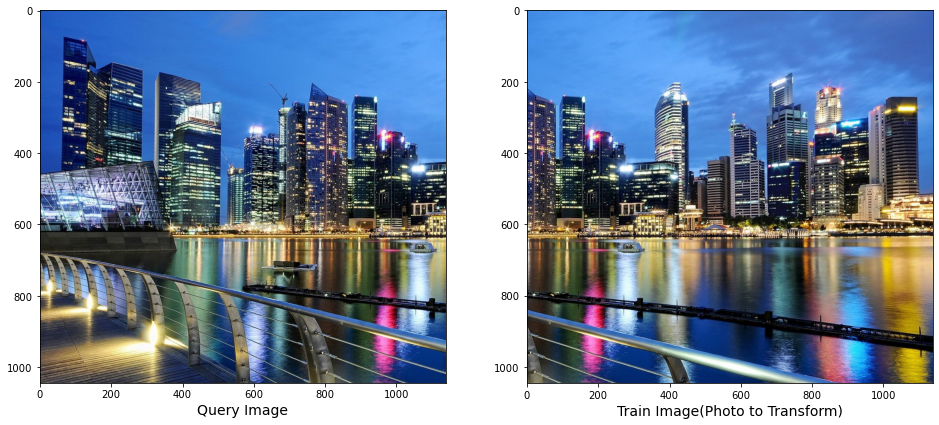

In [6]:
# view the images
fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout = False, figsize=(16,9))
ax1.imshow(query_image, cmap='gray')
ax1.set_xlabel('Query Image', fontsize=14)

ax2.imshow(train_image, cmap='gray')
ax2.set_xlabel('Train Image(Photo to Transform)', fontsize=14)

In [7]:
def select_descriptor_method(image, method=None):
    assert method is not None, "Please define a descriptor method. Accepted values are : 'sift', 'surf', 'orb', 'brisk' "
    
    if method == 'sift':
        descriptor = cv2.SIFT_create()
    
    
    if method == 'surf':
        descriptor = cv2.SURF_create()
        
    
    if method == 'brisk':
        descriptor = cv2.BRISK_create()
        
    
    if method == 'orb':
        descriptor = cv2.ORB_create()
        
    (keypoints, features) = descriptor.detectAndCompute(image, None)
    
    return (keypoints, features)

In [8]:
keypoints_train_img, feature_train_img = select_descriptor_method(train_image_gray, method=feature_extraction_algo)
keypoints_query_img, feature_query_img = select_descriptor_method(query_image_gray, method=feature_extraction_algo)

In [10]:
for keypoint in keypoints_query_img:
    x, y = keypoint.pt
    size = keypoint.size
    orientation = keypoint.angle
    response = keypoint.response
    octave = keypoint.octave
    class_id = keypoint.class_id
    
print(x,y)
print(size)
print(orientation)
print(response)
print(octave)
print(class_id)

1135.169921875 599.8817138671875
2.071977138519287
290.3328552246094
0.045783210545778275
10355199
-1


In [11]:
feature_query_img.shape

(9108, 128)

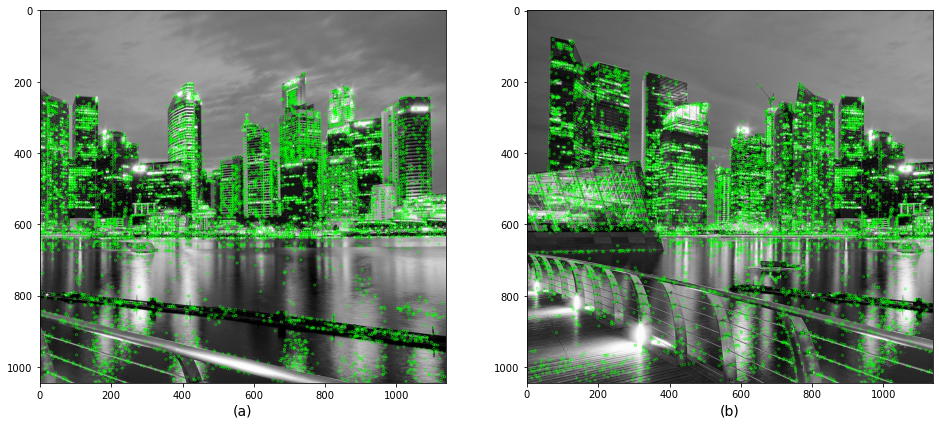

In [26]:
fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout = False, figsize=(16,9))
ax1.imshow(cv2.drawKeypoints(train_image_gray,keypoints_train_img, None, color=(0,255,0)))
ax1.set_xlabel('(a)', fontsize=14)

ax2.imshow(cv2.drawKeypoints(query_image_gray,keypoints_query_img, None, color=(0,255,0)))
ax2.set_xlabel('(b)', fontsize=14)

plt.savefig('./output/' + feature_extraction_algo + '_feature_img' + '.jpeg', bbox_inches = 'tight', dpi=300, optimize=True, format='jpeg')
plt.show()

In [27]:
def create_matching_object(method, crossCheck):
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2,crossCheck=crossCheck)
    elif method == 'orb' or metod == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
            
    return bf

In [14]:
def key_points_matching(feature_train_img,feature_query_img, method):
    bf = create_matching_object(method,crossCheck=True)
    
    best_matches = bf.match(feature_train_img,feature_query_img)
    
    raw_matches = sorted(best_matches, key=lambda x: x.distance) 
    #the matches with smallest distance(with more similarity) are ordered first in the vectors
    
    print('Raw matches with Brute Force', len(raw_matches))
    
    return raw_matches

In [15]:
def key_points_matching_KNN(feature_train_img,feature_query_img,ratio, method = feature_extraction_algo):
    bf = create_matching_object(method,crossCheck=False)
    
    raw_matches = bf.knnMatch(feature_train_img,feature_query_img,k=2)
    
    print('Raw matches with Brute Force', len(raw_matches))
    knn_matches = []
    
    for m,n in raw_matches:
        if m.distance < n.distance*ratio:
            knn_matches.append(m)
    
    return knn_matches

Raw matches with Brute Force 3360


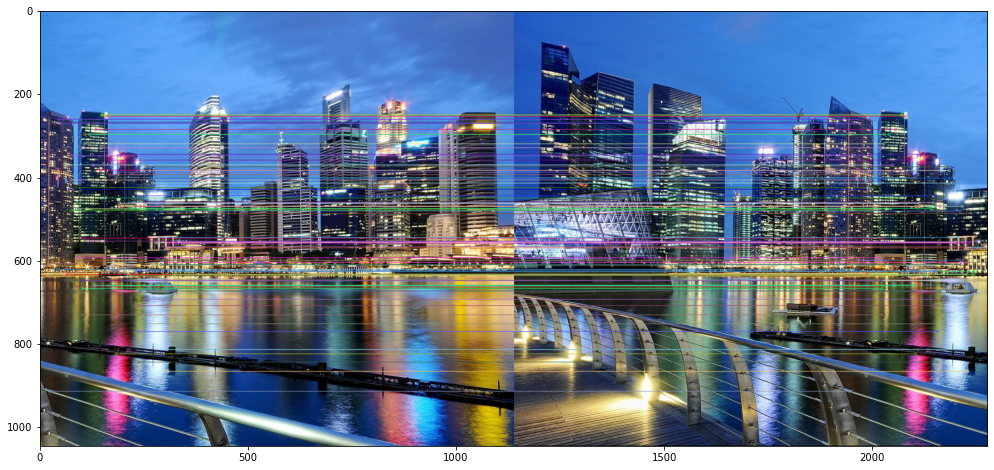

In [16]:
fig = plt.figure(figsize=(20,8))

if feature_to_match == 'bf':
    matches = key_points_matching(feature_train_img, feature_query_img, method=feature_extraction_algo)
    
    mapped_feature_image = cv2.drawMatches(train_image, keypoints_train_img, query_image, keypoints_query_img, matches[:100],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
elif feature_to_match == 'knn':
    matches = key_points_matching_KNN(feature_train_img, feature_query_img,ratio=0.75,method = feature_extraction_algo)
    mapped_feature_image_knn = cv2.drawMatches(train_image, keypoints_train_img, query_image, keypoints_query_img,np.random.choice(matches,100),None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(mapped_feature_image)

Raw matches with Brute Force 8718


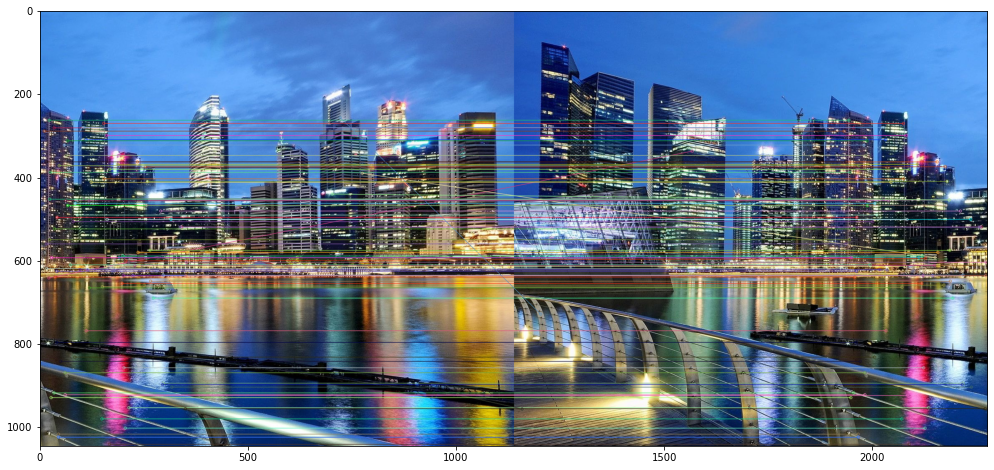

In [17]:
feature_to_match = 'knn'
fig = plt.figure(figsize=(20,8))

if feature_to_match == 'bf':
    matches = key_points_matching(feature_train_img, feature_query_img, method=feature_extraction_algo)
    
    mapped_feature_image = cv2.drawMatches(train_image, keypoints_train_img, query_image, keypoints_query_img, matches[:100],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
elif feature_to_match == 'knn':
    matches = key_points_matching_KNN(feature_train_img, feature_query_img,ratio=0.75,method = feature_extraction_algo)
    mapped_feature_image_knn = cv2.drawMatches(train_image, keypoints_train_img, query_image, keypoints_query_img,np.random.choice(matches,100),None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(mapped_feature_image_knn)

In [18]:
#RANSAC is used to estimate a homography given the descriptors of both images computed with SIFT

In [19]:
def homography_stitching(keypoints_train_img, keypoints_query_img, matches, reprojThresh ):
    
    keypoints_train_img = np.float32([keypoint.pt for keypoint in keypoints_train_img])
    keypoints_query_img = np.float32([keypoint.pt for keypoint in keypoints_query_img])
    
    if len(matches) > 4:
        points_train = np.float32([keypoints_train_img[m.queryIdx] for m in matches])
        points_query = np.float32([keypoints_query_img[m.trainIdx] for m in matches])
        
        (H, status) = cv2.findHomography(points_train,points_query,cv2.RANSAC, reprojThresh)
        
        return (matches, H, status)
    else:
        return None

In [20]:
M = homography_stitching(keypoints_train_img,keypoints_query_img,matches,reprojThresh=4)

if M is None:
    print('Error')
    
(matches, Homography_Matrix, status) = M

print(Homography_Matrix)

[[ 1.00011839e+00  1.02843161e-05  7.81995318e+02]
 [ 1.15604126e-04  1.00001913e+00 -1.31902013e-02]
 [ 1.57457907e-07  8.83865449e-10  1.00000000e+00]]


In [21]:
width = query_image.shape[1] + train_image.shape[1]
print(width)

2276


In [22]:
height = max(query_image.shape[0],train_image.shape[0])
print(height)

1045


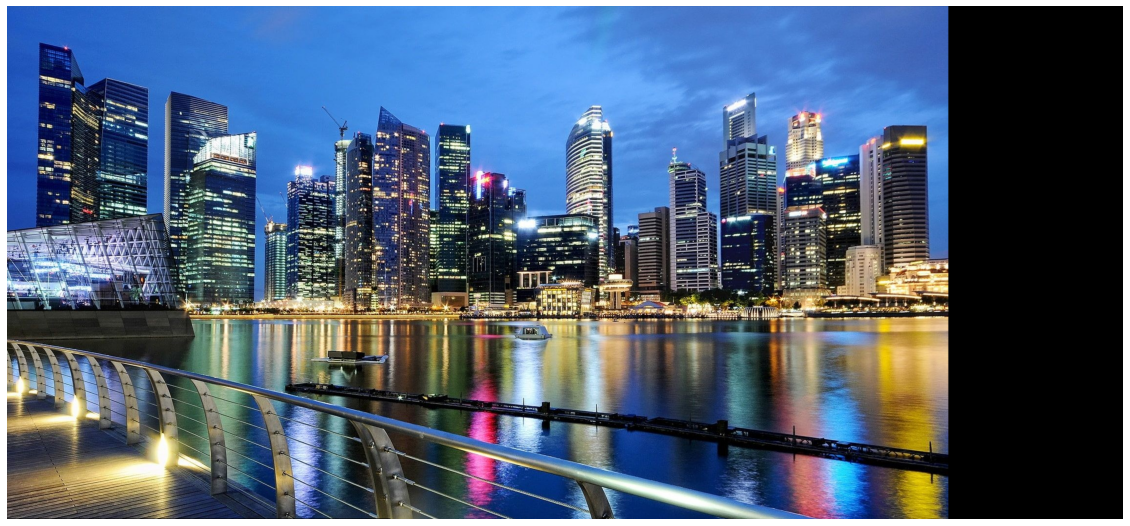

In [32]:
result = cv2.warpPerspective(train_image,Homography_Matrix, (width,height))

result[0:query_image.shape[0],0:query_image.shape[1]] = query_image
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(result)